In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast  # Mixed precision training

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
# Load datasets
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Use pin_memory=True for faster transfers between CPU and GPU
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [6]:
image, label = train_data[0]

In [7]:
image.size() ## shape of image

torch.Size([3, 32, 32])

In [8]:
class_names = train_data.classes

# Print the class names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# Define the NeuralNet
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 12, 5),   # 3 input channels (RGB), 12 output feature maps, 5x5 kernel size
            nn.BatchNorm2d(12),    # Batch Normalization to stabilize learning for 12 channels
            nn.ReLU(),             # ReLU activation function to introduce non-linearity
            nn.MaxPool2d(2, 2)     # Max Pooling to downsample the image by 2x2
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 24, 5),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Shape: (24, 5, 5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(24 * 5 * 5, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5)  # Dropout layer
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fc4 = nn.Linear(64, 10)  # 10 classes
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


In [10]:
# Initialize the network and move to GPU
net = NeuralNet().to(device)
# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [11]:
# For mixed precision training
scaler = GradScaler()

In [12]:
# Early Stopping settings
best_loss = float('inf')
patience = 0
max_patience = 5  # Early stopping after 5 epochs of no improvement


In [13]:
# To store loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [14]:
# Training loop
for epoch in range(30):
    print(f'Training epoch {epoch+1}...')
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()  # Set the network to training mode

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast(): # Runs the forward pass with mixed precision, automatically casting tensors to float16 where appropriate.
            outputs = net(inputs)
            loss = loss_function(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate running loss
        running_loss += loss.item()

        # Calculate accuracy on training set
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Store training loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    net.eval()  # Set the network to evaluation mode
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy on test set
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    # Store test loss and accuracy
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Early stopping check
    if test_loss < best_loss:
        best_loss = test_loss
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            print("Early stopping triggered!")
            break


print('Training complete.')

Training epoch 1...
Epoch 1, Loss: 2.1185, Train Accuracy: 18.23%, Test Loss: 1.8018, Test Accuracy: 31.03%
Training epoch 2...
Epoch 2, Loss: 1.7975, Train Accuracy: 29.92%, Test Loss: 1.5680, Test Accuracy: 39.44%
Training epoch 3...
Epoch 3, Loss: 1.6518, Train Accuracy: 36.48%, Test Loss: 1.4997, Test Accuracy: 42.60%
Training epoch 4...
Epoch 4, Loss: 1.5651, Train Accuracy: 40.91%, Test Loss: 1.3923, Test Accuracy: 48.31%
Training epoch 5...
Epoch 5, Loss: 1.4875, Train Accuracy: 44.94%, Test Loss: 1.3335, Test Accuracy: 51.08%
Training epoch 6...
Epoch 6, Loss: 1.4111, Train Accuracy: 48.31%, Test Loss: 1.2795, Test Accuracy: 53.31%
Training epoch 7...
Epoch 7, Loss: 1.3491, Train Accuracy: 51.58%, Test Loss: 1.2174, Test Accuracy: 56.58%
Training epoch 8...
Epoch 8, Loss: 1.3052, Train Accuracy: 54.06%, Test Loss: 1.1518, Test Accuracy: 59.02%
Training epoch 9...
Epoch 9, Loss: 1.2639, Train Accuracy: 55.44%, Test Loss: 1.1306, Test Accuracy: 60.37%
Training epoch 10...
Epoch 1

In [15]:
# Visualizing convolution layer outputs
def visualize_conv_layer(model, image):
    activations = {}
    def hook_fn(module, input, output):
        activations['layer'] = output

    model.conv1[0].register_forward_hook(hook_fn)
    model(image.unsqueeze(0))  # Pass single image

    act = activations['layer'].cpu().squeeze().detach().numpy()
    fig, axs = plt.subplots(1, act.shape[0], figsize=(15, 5))
    for i in range(act.shape[0]):
        axs[i].imshow(act[i], cmap='gray')
        axs[i].axis('off')
    plt.show()

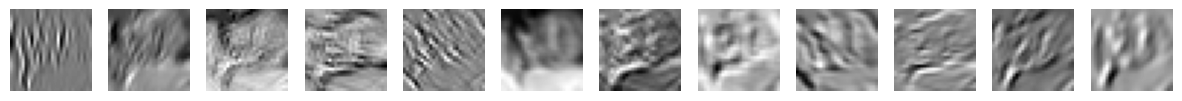

In [16]:
# Visualize one test image's first conv layer
example_img, _ = test_data[0]
visualize_conv_layer(net, example_img.to(device))


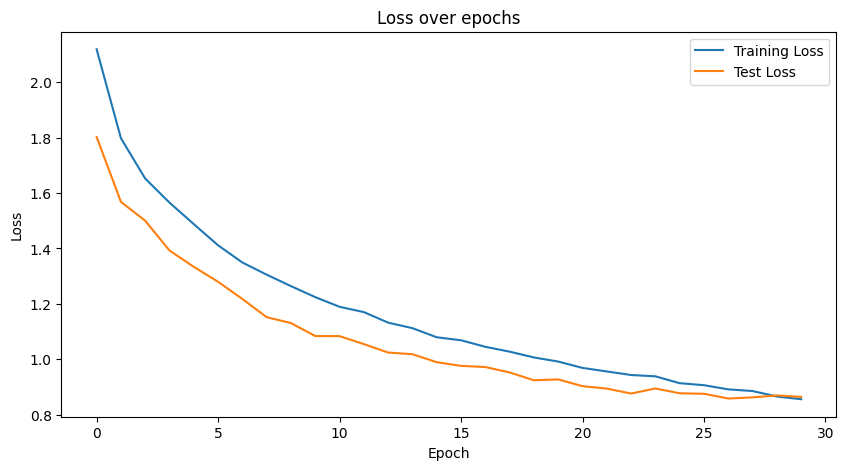

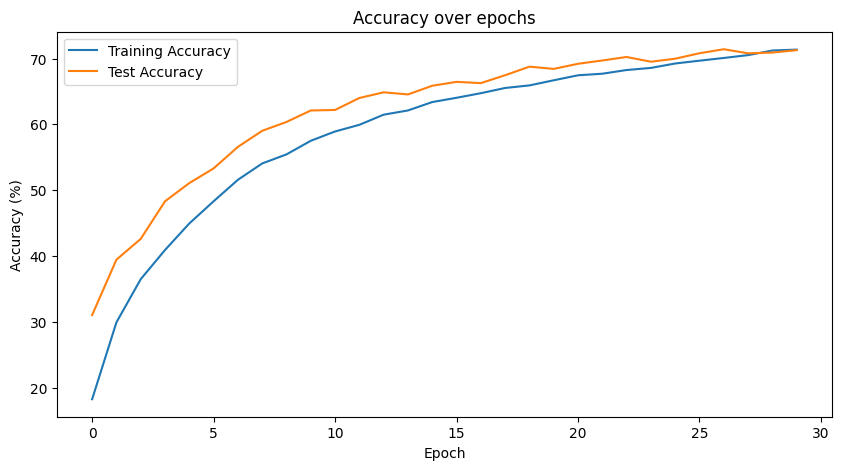

In [17]:
# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

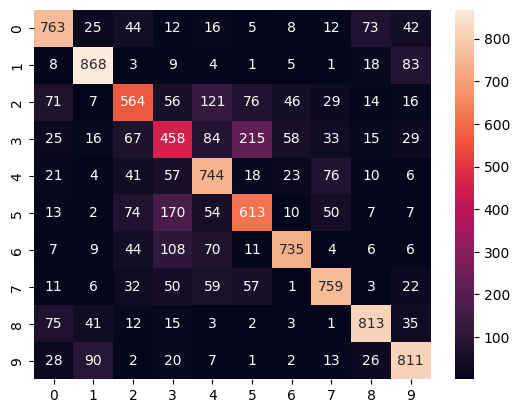

In [18]:
# Confusion Matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)s
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [19]:
class_names = train_data.classes

# Print the class names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
